<a href="https://colab.research.google.com/github/ShuaimingJing/XAI_assignment/blob/main/Assignment10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment #10
Name: Shuaiming Jing

Youtube link for Video explaining the saliency map to a C-suite executive: https://youtu.be/wTHeVYyZdvs  



# Code tutorial for to explain saliency map in python

A saliency map is an interpretability tool used in deep learning, particularly for image classification models, to highlight which pixels or regions of an image are most important for the model's prediction. It visualizes the gradient of the model’s output with respect to the input image, showing how much each pixel influenced the classification decision.

In other words, a saliency map indicates the areas of focus in an image that the model relies on when making its prediction. Brighter regions in the map correspond to pixels that had a higher impact on the prediction, while darker regions had less influence.


### Model & Image setup

In [1]:
!pip install numpy==1.25.2 matplotlib==3.7.1 tensorflow==2.14.1


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.9/489.9 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.1 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: keras
    Found existing installation: keras 3

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Load the pre-trained model
model = ResNet50(weights='imagenet')

# Load and preprocess the image
img_path = '/content/umbrella.png'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Convert the numpy array to a TensorFlow tensor
img_tensor = tf.convert_to_tensor(img_array)

102967424/102967424 [==============================] - 0s 0us/step


### Get model's predicition for classification

35363/35363 [==============================] - 0s 0us/step
Top Prediction: umbrella 


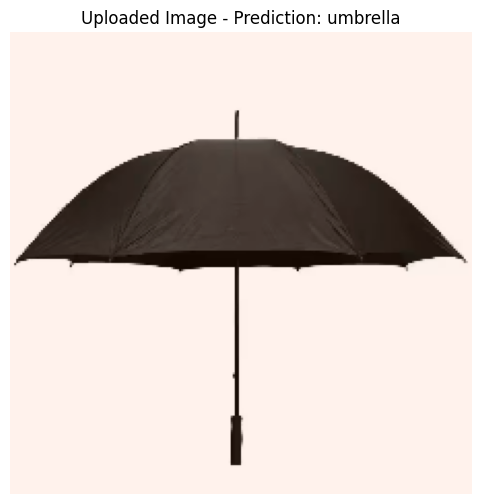

In [3]:
# Get model predictions
preds = model(img_tensor)

# Convert the predictions from Tensor to NumPy array
preds_numpy = preds.numpy()

# Decode the top prediction only
decoded_preds = decode_predictions(preds_numpy, top=1)[0]  # Get only the top 1 prediction

# Print the top predicted class and its probability
imagenet_id, label, score = decoded_preds[0]
print(f"Top Prediction: {label} ")

# Show the uploaded image
plt.figure(figsize=(6, 6))
plt.imshow(image.array_to_img(img_array[0]))  # Convert back to image format and display
plt.title(f"Uploaded Image - Prediction: {label}")
plt.axis('off')
plt.show()

### Get Saliency Map

Before getting to the coding stuffs, one important concept needed to be introduced is gradient tape. Gradient Tape is a tool in TensorFlow that allows you to automatically record operations for calculating gradients.

**How does it work:**

1. Recording Operations: Gradient Tape “watches” the operations performed on tensors, allowing it to trace how each value is computed.
2. Computing Gradients: Once the computation is recorded, Gradient Tape can compute the gradients of certain outputs (e.g., the model's predictions) with respect to specific inputs (e.g., the input image). These gradients tell  how sensitive the output is to changes in each input.
3. Applying Gradients: After computing the gradients, we will use it to generate saliency maps to visualize influential features by calculating the absolute value of the gradients.



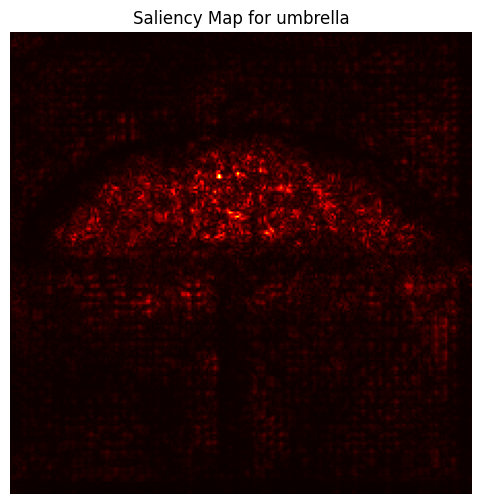

In [4]:
# Get the index of the predicted class
class_idx = tf.argmax(preds[0])

# Set up GradientTape to compute gradients
with tf.GradientTape() as tape:
    tape.watch(img_tensor)  # Watch the input image tensor
    preds = model(img_tensor)
    top_class_output = preds[:, class_idx]  # Focus on the predicted class

# Compute gradients of the top predicted class with respect to the input image
grads = tape.gradient(top_class_output, img_tensor)

# Compute the absolute value of the gradients to get the saliency map
saliency = tf.reduce_max(tf.abs(grads), axis=-1)[0]

# Normalize the saliency map for visualization
saliency = (saliency - tf.reduce_min(saliency)) / (tf.reduce_max(saliency) - tf.reduce_min(saliency))

# Plot the saliency map
plt.figure(figsize=(6, 6))
plt.imshow(saliency, cmap='hot')
plt.title(f'Saliency Map for {label}')
plt.axis('off')
plt.show()


According to the saliency map of the umbrella, the model primarily focus on the top portion of the umbrella canopy, where the curve is most pronounced. This part likely serves as a distinguishing feature of the umbrella, as the unique curvature and shading patterns help the model identify it.

There is also a faint outline of attention along the umbrella handle, though it is less prominent than the canopy. This suggests that while the handle is relevant, it’s not as crucial as the shape and structure of the canopy for the model’s classification.

The outer edges of the canopy and the background show minimal to no attention in the saliency map. This indicates that the model considers these regions less important for identifying the object. It suggests that the model relies more on specific contours and texture patterns near the center of the canopy rather than the edges or background.